# First implementation of a GNN (GCN)
In this notebook, we build the graph from an initial dataframe, and we execute the first implementation of our GNN, which contains 1 convolutive layer and 1 fully-connected layer.

## Notebook plan : 
1. Building the graph
2. Building the GCN
3. Train the GCN

In [23]:
import pandas as pd
import numpy as np
from models.BuildGraph import BuildGraph
from models.GCN import GCN
from manage.GCNTrainTestManager import GCNTrainTestManager
import torch

## 1. Building the graph
Here, we split the patients by tumour type. We merge tumour types if they contain only 1 patient.

### Reading the dataset

In [24]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df["Clinical benefit"] = np.where(df["Clinical benefit"]=="DCB",1,0)
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,0,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,0,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,0,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,0,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,0,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,1,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,0,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,0,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,0,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


In [25]:
buildgraph = BuildGraph(df)

### Compute the adjacency matrix

In [26]:
buildgraph.compute_adjacency_matrix("Tumour type")
display(buildgraph.A)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Build the graph

In [27]:
features_label = ["CD8+ T cell score","Exome mut per mb"]
y_label = "Clinical benefit"

buildgraph.create_graph(features_label, y_label)

### Show the graph

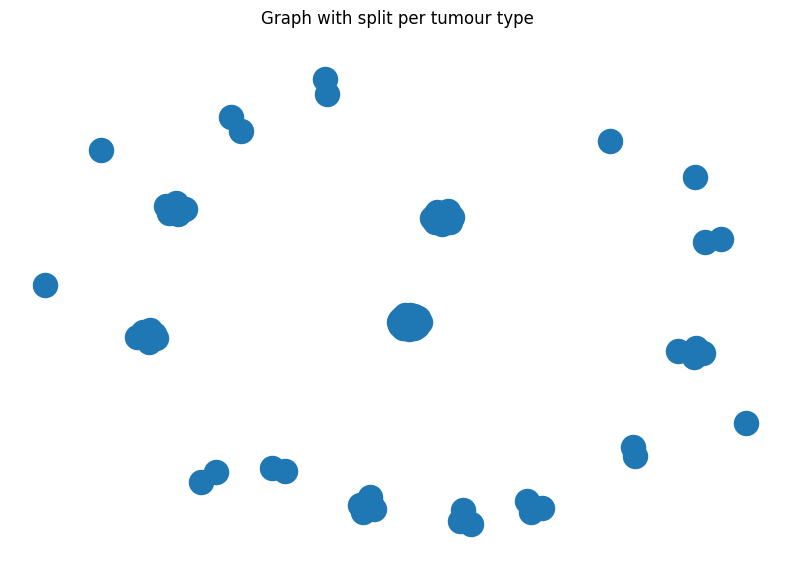

In [28]:
buildgraph.show_graph("Graph with split per tumour type","tumour-type.png")

## 2. Building the GCN

### Formatting data
We convert the Networkx graph to a PyTorch Geometric graph.

In [29]:
from torch_geometric.utils.convert import from_networkx

pyg_graph = from_networkx(buildgraph.G)

### Instanciate the GCN

In [30]:
model = GCN(2)
print(model)

GCN(
  (conv): GCNConv(2, 2)
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


## 3. Training the GCN

In [31]:
# Define loss function and optimizer and instanciate the trainer
loss_function = torch.nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = GCNTrainTestManager(model, pyg_graph, loss_function, optimizer)

In [32]:
# Train
trainer.train(n_epochs=100)

Epoch 1 of 100
Epoch 11 of 100
Epoch 21 of 100
Epoch 31 of 100
Epoch 41 of 100
Epoch 51 of 100
Epoch 61 of 100
Epoch 71 of 100
Epoch 81 of 100
Epoch 91 of 100
End of training.


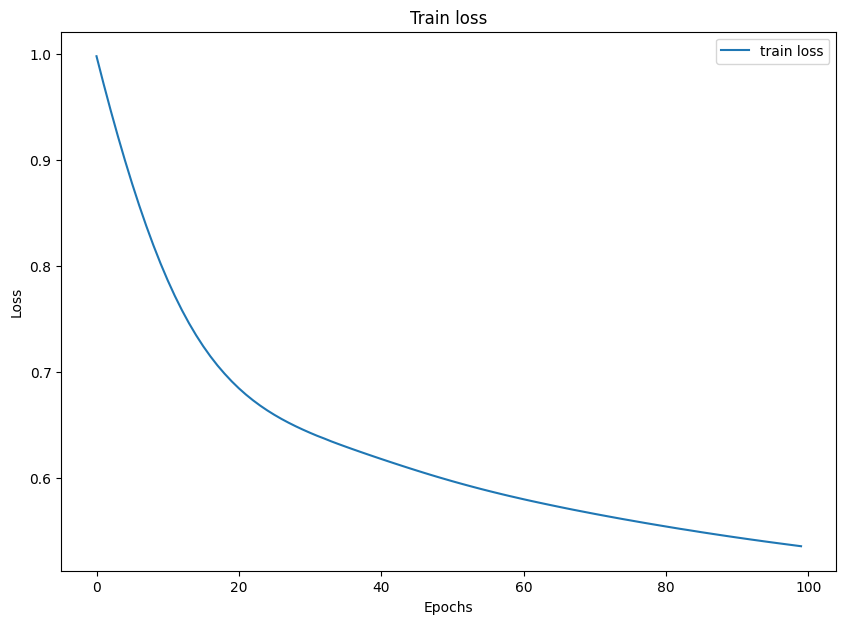

In [33]:
# Plot loss function
trainer.plot_loss()